### Imports and set up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
#torch imports 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from sklearn.model_selection import train_test_split
from torcheeg import transforms
from torcheeg.models.gnn.dgcnn import GraphConvolution
# helper sctipts 
from training import TrainNN
from cka import CKACalculator

## Path constants
data_path = "../data/"
preprocessed_data_path = "preprocessed_data.npy"

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(data_path), io_mode='lmdb')

## Read metadata dataframeimports
metadata = pd.read_csv(data_path + 'sample_metadata.tsv', sep='\t')

### Load data

In [2]:
# Verifying connection to data
idxs = np.arange(len(metadata))

# Read features and labels as torch tensors
X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
y = torch.tensor(metadata["value"].values, dtype=torch.long)

In [3]:
if os.path.exists(preprocessed_data_path):
    
    with open(preprocessed_data_path, "rb") as f:
        X_bde = np.load(f)
    
else:
    t = transforms.BandDifferentialEntropy(band_dict={
                              "delta": [1, 4],
                              "theta": [4, 8],
                              "alpha": [8, 14],
                              "beta": [14, 31],
                              "gamma": [31, 49]
                          })

    X_bde = []
    for i in range(X.shape[0]):

        bde_tmp = t(eeg=X[i])
        X_bde.append(bde_tmp)

    X_bde = [x["eeg"] for x in X_bde]

    with open(preprocessed_data_path, "wb") as f:
        np.save(f, X_bde)

X_bde = torch.FloatTensor(X_bde)      

### Split data into train, validation and test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_bde, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [5]:
# get dimensions

nsamples_train, nchannels_train, bands = X_train.shape
nsamples_val, nchannels_val, bands = X_val.shape

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

### Training & model hyperparameters

In [6]:
# Model parameters
n_chans = 5
n_electrodes = 22
n_outputs = y.max().item() + 1
n_layers = 2
hid_chans = 32

# Training parameters
lr = 1e-4
epochs = 40
w_decay = 0

#Models 
modruns = 4
path="artifacts"
modelname="dgcnn_mod"
plot=False

## Train model

### Train 4 models and calculate CKA matrices for pairs of models

In [7]:
mods = []

def train_models(model,modeltrainer,num_models=1,new =False, prints=False):
    """
    Training a model with random initialisation but consitent parameters. 
    
    Hyper parameters should be set outside of this function 
    
    path and model_names are both needed parameters that need to be defined outside of this function. 
    
    Path is to where your artifacts are located and model_name is what the model is called 
    
    ...
    
    Parameters
    -----------
    model : nn.modules
        The model being trained
    modeltrainer : training class
        a class for training the model provided should return a trained model
    num_models : int 
        Default 1, how many models it trains
    new : bool
        Weather it should attempt to use saved models
    """
    for i in range(num_models):
        
        tmp_mod=model
        pth=f"{path}/{modelname}{i}.pth"
        
        if new or not os.path.exists(pth):    
            if not os.path.exists(pth):
                print(f"Could not resolve path: {pth}")
            trainer = modeltrainer()
            mods.append(trainer.train_model(tmp_mod, train_loader, val_loader, learning_rate=lr,pth=path,name=modelname,
                                            w_decay=w_decay,epochs=epochs, prints=prints, modrun=i))
        else: 
            tmp_mod.load_state_dict(torch.load(pth))
            tmp_mod.eval()
            mods.append([tmp_mod,[]])
            

# Training 4 models 
train_models(DGCNN(in_channels=n_chans, num_electrodes=n_electrodes, hid_channels=hid_chans,
                    num_layers=n_layers, num_classes=n_outputs),TrainNN,num_models=modruns,prints=plot)

In [8]:
cka_all = []  
for i, j in itertools.combinations(range(modruns), 2):
    calculator = CKACalculator(model1=mods[i][0], model2=mods[j][0], dataloader=train_loader,
                               layers_to_hook=(nn.Conv2d, nn.Linear, nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
    cka_output = calculator.calculate_cka_matrix()
    cka_all.append(cka_output)
    if plot:
        #Plot the matrix
        plt.figure(figsize=(7, 7))
        plt.imshow(cka_output.cpu().numpy(), cmap='inferno')
        plt.xticks(ticks=np.arange(len(calculator.module_names_X)), labels=calculator.module_names_X, ha="right")
        plt.yticks(ticks=np.arange(len(calculator.module_names_Y)), labels=calculator.module_names_Y)
        plt.colorbar()
        plt.title(f'CKA Matrix: Model {i} vs Model {j}')
        plt.show()


Processing CKA: 100%|██████████| 49/49 [00:00<00:00, 287.55it/s]


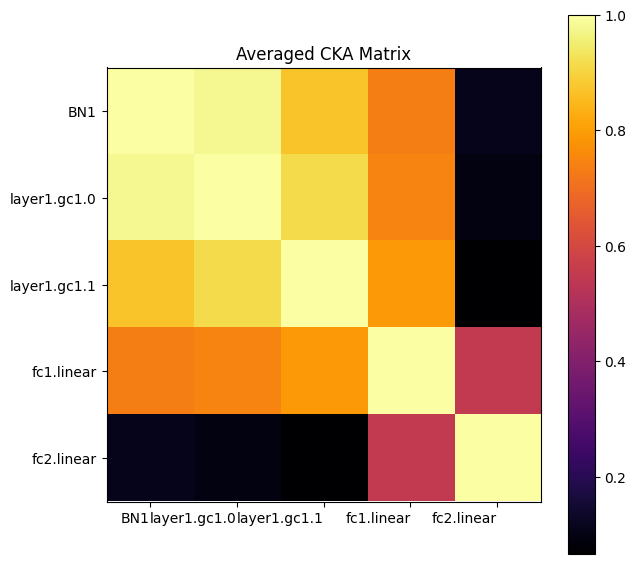

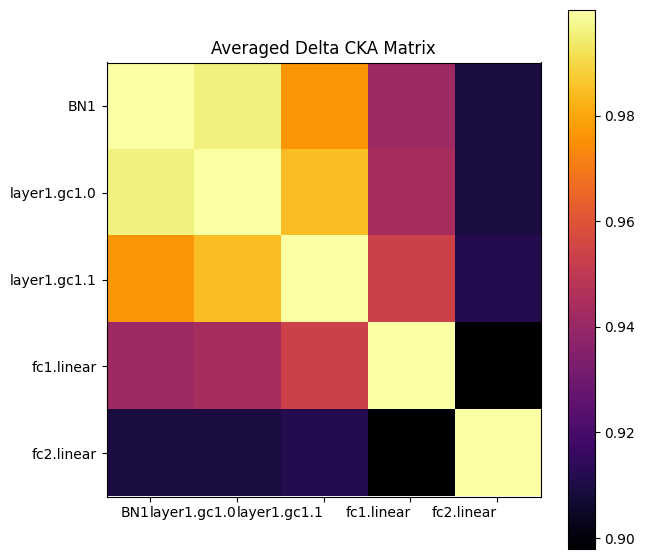

In [9]:
cka_stack = torch.stack(cka_all) 
average_cka_matrix = cka_stack.mean(dim=0)
delta_matrices = []
for mat1, mat2 in itertools.combinations(cka_stack, 2):
    delta_matrices.append(torch.abs(mat1 - mat2)) 
delta_matrices = torch.stack(delta_matrices)  
average_delta_cka_matrix =1- delta_matrices.mean(dim=0)  


plt.figure(figsize=(7, 7))
plt.imshow(average_cka_matrix.cpu().numpy(), cmap='inferno')
plt.xticks(ticks=np.arange(len(calculator.module_names_X)), labels=calculator.module_names_X, ha="right")
plt.yticks(ticks=np.arange(len(calculator.module_names_Y)), labels=calculator.module_names_Y)
plt.colorbar()
plt.title("Averaged CKA Matrix")
plt.show()


plt.figure(figsize=(7, 7))
plt.imshow(average_delta_cka_matrix.cpu().numpy(), cmap='inferno')
plt.xticks(ticks=np.arange(len(calculator.module_names_X)), labels=calculator.module_names_X, ha="right")
plt.yticks(ticks=np.arange(len(calculator.module_names_Y)), labels=calculator.module_names_Y)
plt.colorbar()
plt.title("Averaged Delta CKA Matrix")
plt.show()


In [ ]:
for i  in range (len(mods)):
    plt.plot(mods[0][1][0])
    plt.plot(mods[0][1][1])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["training loss","validation loss"])
    plt.title(f"Model{i} Training vs validation loss")
    plt.show()  

IndexError: list index out of range